<a href="https://colab.research.google.com/github/aryanosho/Physics-Informed-Neural-Networks-PyTorch/blob/master/Question1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Answer to the questions in the pdf file

# Importing Libraries

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable


#Neural Network Architecture

In [167]:

class Neural_Net(nn.Module):                               
    def __init__(self):
        super(Neural_Net, self).__init__()
        self.hidden_layer1 = nn.Linear(1,64)
        self.hidden_layer2 = nn.Linear(64,256)               # 5 hidden layers and one output layer
        self.hidden_layer3 = nn.Linear(256,256)
        self.hidden_layer4 = nn.Linear(256,256)
        self.hidden_layer5 = nn.Linear(256,64)
        self.output_layer = nn.Linear(64,1)        

    def forward(self, x):                      # function to predict the value of u at given x
        inputs = x
        layer1_out = torch.tanh(self.hidden_layer1(inputs))              #We use tanh activation function as it is bounded,smooth and differentiable at all points
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output
# We use cuda if available else cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Creating object of Neural network class

In [168]:
net = Neural_Net()
net = net.to(device)


 Generating 100 random points between 0 and 1

In [169]:
# Generating 100 data points
p= np.random.uniform(low=0.0, high=1, size=(100,1))
x=np.append(p,[[0.0],[1.0],[1.0],[0.0],[1.0],[0.0]])
x=x.reshape(-1,1)
def u_true(x):
  return (8*x*(-1+x*x)-(3*np.sin(4*np.pi*x)/(np.pi*np.pi)))/48
u=u_true(x)


In [170]:
a = torch. tensor ([1.2], requires_grad=True) .to(device)
b = torch. tensor ([1.3], requires_grad=True) .to(device)
c = torch. tensor ([13.0], requires_grad=True).to(device)

a = torch.nn.Parameter(a)
b= torch.nn. Parameter(b)
c=torch.nn.Parameter(c)

net.register_parameter('a',a)
net.register_parameter('b',b)
net.register_parameter('c',c)



# Calculating residual

In [171]:
mse_cost_function = torch.nn.MSELoss()     # loss fn to be used for calculating physics informed loss

def f(x, net):
    u = net(x)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]            #calculate first derivative of u wrt x
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]         #calculate second derivative of u wrt x
    residual = u_xx - net.a*x-net.b*torch.sin(net.c*x)                            # according to the DE given                                                         
    return residual

optimizer = torch.optim.Adam(net.parameters())         # adam optimizer

# boundary condition

In [172]:
x_bc = np.array([[0],[1]])      # at x=0 u=0, at x=1 u=0
u_bc = np.array([[0],[0]])

#Generating collocation points and then Training

In [173]:
iterations = 2500   # no. of iter
losses=[]
for epoch in range(iterations):
    optimizer.zero_grad() #  gradients= zero at each epoch
    
    # Data loss

    tensor_x = Variable(torch.from_numpy(x).float(), requires_grad=False).to(device)      # converting numpy array to tensor 
    tensor_u = Variable(torch.from_numpy(u).float(), requires_grad=False).to(device)
    net_out = net(tensor_x)                        # output of NN at boundary condition
    mse_Data = mse_cost_function(net_out,tensor_u)  # Boundary loss
    
    # Physics informed loss
    zeros = np.zeros((106,1))     
    tensor_x= Variable(torch.tensor(x).float(), requires_grad=True).to(device)   # converting numpy array to tensor
    tensor_zeros = Variable(torch.tensor(zeros).float(), requires_grad=False).to(device)
    
    
    f_out = f(tensor_x,net) # residual
    mse_PIL = mse_cost_function(f_out, tensor_zeros)  #Physics informed loss
    
    # Combining the loss functions
    loss = mse_Data + mse_PIL
    
    losses.append(loss.data.cpu())
    loss.backward() # Calculating gradients using backward propagation
    optimizer.step() # updating gradies of loss function

    with torch.autograd.no_grad():
    	print(epoch,"Traning Loss:",loss.data)


0 Traning Loss: tensor(1.3806, device='cuda:0')
1 Traning Loss: tensor(1.1805, device='cuda:0')
2 Traning Loss: tensor(1.1250, device='cuda:0')
3 Traning Loss: tensor(1.0089, device='cuda:0')
4 Traning Loss: tensor(0.9110, device='cuda:0')
5 Traning Loss: tensor(0.8562, device='cuda:0')
6 Traning Loss: tensor(0.8050, device='cuda:0')
7 Traning Loss: tensor(0.8769, device='cuda:0')
8 Traning Loss: tensor(0.8572, device='cuda:0')
9 Traning Loss: tensor(0.8712, device='cuda:0')
10 Traning Loss: tensor(0.8153, device='cuda:0')
11 Traning Loss: tensor(0.7906, device='cuda:0')
12 Traning Loss: tensor(0.7865, device='cuda:0')
13 Traning Loss: tensor(0.7809, device='cuda:0')
14 Traning Loss: tensor(0.7878, device='cuda:0')
15 Traning Loss: tensor(0.7948, device='cuda:0')
16 Traning Loss: tensor(0.7877, device='cuda:0')
17 Traning Loss: tensor(0.7717, device='cuda:0')
18 Traning Loss: tensor(0.7577, device='cuda:0')
19 Traning Loss: tensor(0.7448, device='cuda:0')
20 Traning Loss: tensor(0.7301

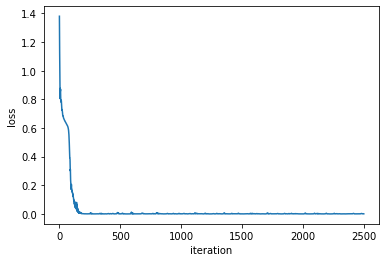

In [174]:
p=np.arange(1,2501,1)     
plt.plot(p,losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()
    

In [175]:
p=np.arange(0,1,.01)
p=p.reshape(-1,1)
x1 = torch.from_numpy(x)
TV=[]                   #for storing true values
PV=[]                   # for storing predicted values

for i in p:
  true_value= (8*i*(-1+i*i)-(3*np.sin(4*np.pi*i)/(np.pi*np.pi)))/48
  TV.append(true_value)

predicted_value=net(Variable(torch.from_numpy(p).float(), requires_grad=False).to(device))
res=predicted_value.cpu().detach().numpy()
  


a: [1.152682]
b: [1.1749741]
c: [12.885933]


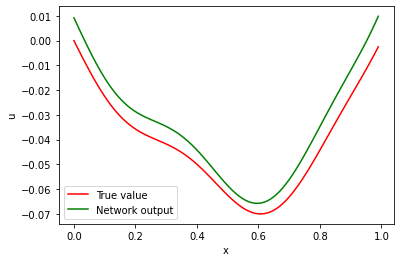

In [176]:
print('a:',net.a.data.cpu().numpy())
print('b:',net.b.data.cpu().numpy())
print('c:',net.c.data.cpu().numpy())
import matplotlib.pyplot as plt
plt.plot(p,TV,color='r',label='True value')
plt.plot(p,res,color='g',label='Network output')

plt.xlabel("x")
plt.ylabel("u")
plt.legend()  

  
# To load the display window
plt.show()